In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import tempfile
tempdir = tempfile.gettempdir()

# Functional model: the basics

The `Sequential` model
- organizes layers as an ordered list
- restricts the input to layer $(\ll+1)$ to be the output of layer $\ll$.

The computation of a Sequential model is easy to describe and picture
- a graph
- each node represents the computation of a layer
- the nodes are connected sequentially in a straight line
- single input, single output
    - mostly true
    - can have inputs/outputs that are arrays, each element representing a different input/output value

The Functional model
- imposes **no** ordering on layers
- imposes **no** restriction on connect outputs of one layer to the input of another

The computation of a Functional model can be pictured as a general graph
- each node represents a computation
- edges can flow from any node to any other 
    - non-cyclic
- multiple inputs, multiple outputs possible

To illustrate the `Functional` model let's take a first look
at model implementing a single `Transformer` block
- we will revisit this code later to illustrate other concepts

Here is the picture of a Transformer block

<table>
    <tr>
        <th><center>Transformer (Encoder/Decoder)</center></th>
    </tr>
    <tr>
        <td><img src="images/Attention_is_all_u_need_Transformer.png" width=50%></td>
    </tr>
</table>

We can identify some connections that *don't* flow sequentially between adjacent nodes
- the *skip connection* that bypasses 
    - the Multi-Head Attention node in the Encoder and the top Multi-Head Attention node in the Decoder
    - the Masked Multi-Head Attention node in the Decoder
- the connection from the output of the Encoder (top left) to the input of the Decoder Multi-Head Attention node

# The Functional Model architecture,  in code

[reference](https://www.tensorflow.org/guide/keras/functional)

In the Sequential model, the output of the node representing layer $\ll$ is *always*
fed to the input of the node representing layer $(\ll +1)$
- So can describe the computation graph as a sequence of nodes (each node a `Layer` type)

In the Functional model a node represents a function that takes one or more inputs and produces an output
- the node does not need to be a `Layer`
    - any TensorFlow `op`
- we connect the output of node $\node{N_a}$ to the input of node $\node{N_b}$
    - by assigning the output of $\node{N_a}$ to a variable (typically denoted as `x`)
    - calling the computation of $\node{N_b}$ with the variable as actual parameter
        


Here is an example ([source](https://www.tensorflow.org/api_docs/python/tf/keras/Model))

```
import tensorflow as tf

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

```


- There is an `Input` layer (a function with no argument) whose output is assigned to variable `inputs`
- There is a `Dense` layer (a function with a single argument and single output)
    - that is called with parameter `inputs`
    - assigns its result to variable `x`

In general, these variables could be used as arguments (i.e., node inputs) anywhere in the computation
- not necessarily the next function appearing sequentially

The collection (not necessarily a sequence) of function calls defines a *Directed Acyclic Graph*
- one or more *root* nodes representing graph inputs
- one of more *leaf* nodes representing graph outputs

The graph encodes a complex function mapping inputs to outputs, composed of simpler functions.

The graph can be used to implement
- a new `Layer`
- a complete `Model`

To turn this collection into a `Model`
- we specify the input nodes
- we specify the output nodes

For example, for the above graph:

```
model = tf.keras.Model(inputs=inputs, outputs=outputs)
```
 
When `model` is *called*
- the actual parameters are bound to the nodes identified as inputs
    - i.e., `inputs`
- the result of the call are the values associated with the nodes identified as 
    - i.e., `outputs`
`

Since a graph can have multiple inputs and outputs
- the `input` and `output` parameters of the `Model` statement can be *lists*

[`Model` reference](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

## Example: multiple inputs and outputs

Here is an example (taken from [the reference](https://www.tensorflow.org/guide/keras/functional#models_with_multiple_inputs_and_outputs))
- Takes three inputs: title, body, tags
    - title: sequence of `int`
    - body: sequence of `int`
    - tags: binary vector (of length `num_tags`)
- Reduces each variable length sequence to a fixed length representation (final state of an LSTM)
- Concatenates the fixed length representations of title and body with the tags
- Feeds the concatenated vector to **two separate classifiers**
- Produces two outputs
    - priority: the output of one classifier
    - department: the output of the other classifier

In [3]:

num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

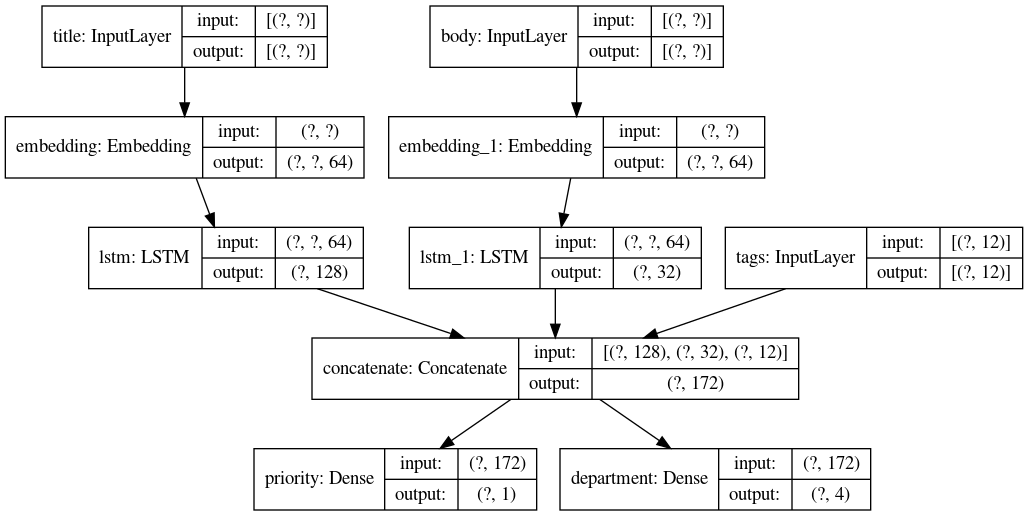

In [4]:
keras.utils.plot_model(model, os.path.join(tempdir,"multi_input_and_output_model.png"), show_shapes=True)


Observe
- The 3 input nodes
    - separate processing path
- The 2 output nodes
    - separate classifiers


## Example: Nested Models

A `Model` and a `Layer` are very similar
- mapping inputs to outputs

Let's illustrate with an Autoencoder.

<table>
    <tr>
        <th><center>Autoencoder</center></th>
    </tr>
    <tr>
        <td><img src="images/Autoencoder_vanilla.png"></td>
    </tr>
</table>

Here is an example (taken from [the reference](https://www.tensorflow.org/guide/keras/functional#all_models_are_callable_just_like_layers))

In [5]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

Let's examine the `autoencoder` model
- it is composed of two models
    - `encoder`
    - `decoder`

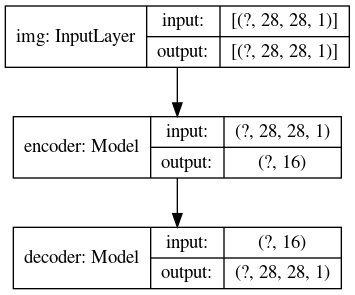

In [6]:
keras.utils.plot_model(autoencoder, os.path.join(tempdir,"autoencoder.png"), show_shapes=True)


We can examine the sub-models:

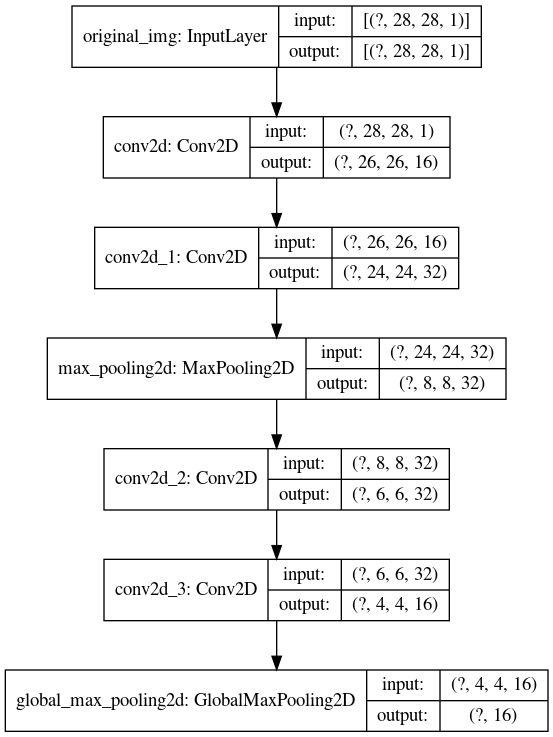

In [7]:
keras.utils.plot_model(encoder, os.path.join(tempdir,"encoder.png"), show_shapes=True)


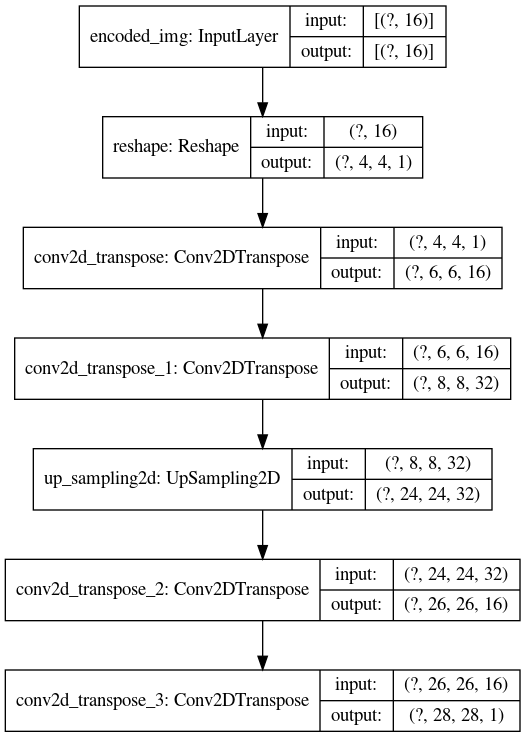

In [8]:
keras.utils.plot_model(decoder, os.path.join(tempdir, "decoder.png"), show_shapes=True)


## Example: shared layers

You can use the layers of one `Model` within another `Model`.

For example, here is a way to examine the intermediate layers of a very deep model (the VGG19 image classifier).

First: let's examine the deep model architecture:

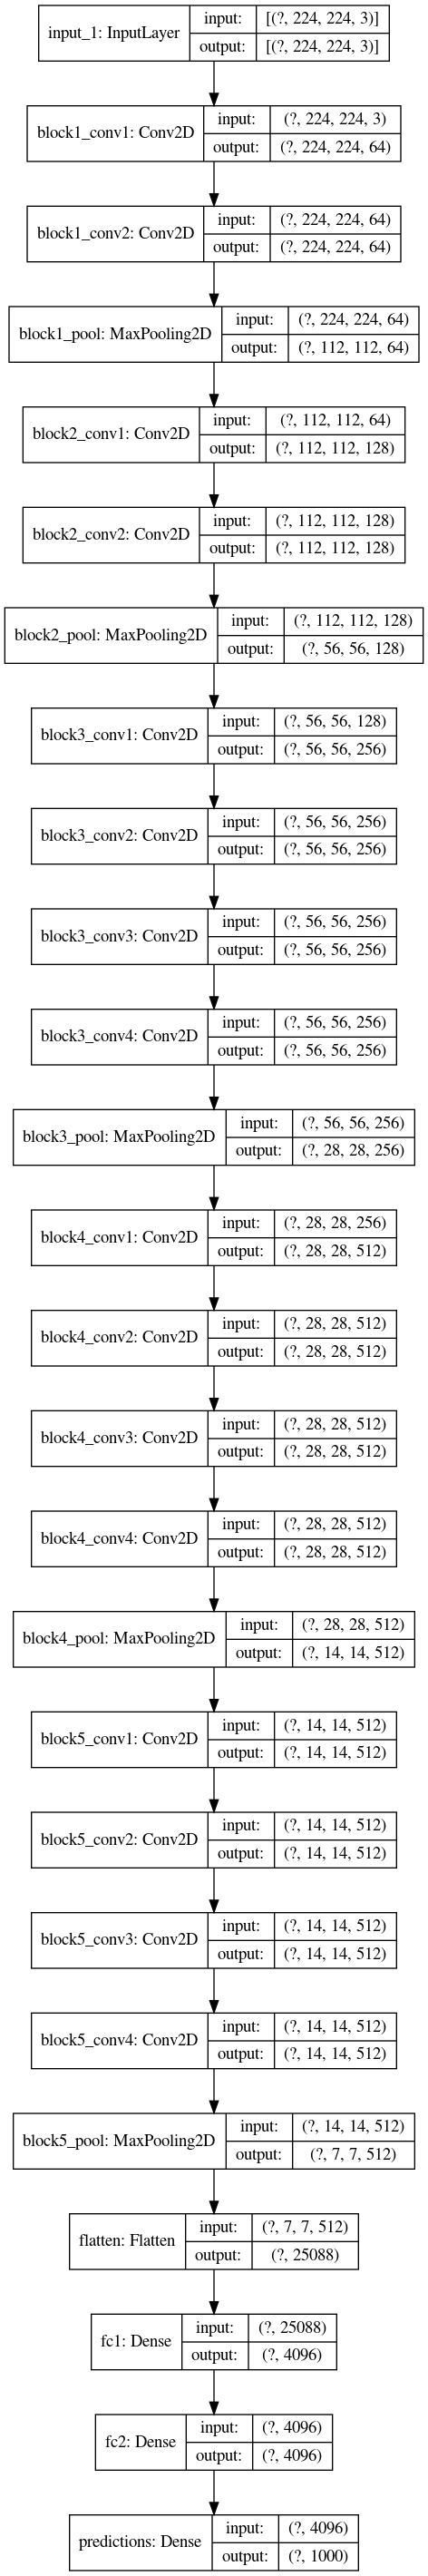

In [9]:
vgg19 = tf.keras.applications.VGG19()

keras.utils.plot_model(vgg19, os.path.join(tempdir,"vgg19.png"), show_shapes=True)


And here we create a new `Model`
- takes as an image as input: same as VGG19
- produces a list
    - output of *each layer* of VGG19, given the input image
    
We call this a **feature extractor**

In [10]:
features_list = [layer.output for layer in vgg19.layers]

feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

In [11]:
for i, layer_out in enumerate(extracted_features):
    print(f"Layer {i} shape: {layer_out.shape}")

Layer 0 shape: (1, 224, 224, 3)
Layer 1 shape: (1, 224, 224, 64)
Layer 2 shape: (1, 224, 224, 64)
Layer 3 shape: (1, 112, 112, 64)
Layer 4 shape: (1, 112, 112, 128)
Layer 5 shape: (1, 112, 112, 128)
Layer 6 shape: (1, 56, 56, 128)
Layer 7 shape: (1, 56, 56, 256)
Layer 8 shape: (1, 56, 56, 256)
Layer 9 shape: (1, 56, 56, 256)
Layer 10 shape: (1, 56, 56, 256)
Layer 11 shape: (1, 28, 28, 256)
Layer 12 shape: (1, 28, 28, 512)
Layer 13 shape: (1, 28, 28, 512)
Layer 14 shape: (1, 28, 28, 512)
Layer 15 shape: (1, 28, 28, 512)
Layer 16 shape: (1, 14, 14, 512)
Layer 17 shape: (1, 14, 14, 512)
Layer 18 shape: (1, 14, 14, 512)
Layer 19 shape: (1, 14, 14, 512)
Layer 20 shape: (1, 14, 14, 512)
Layer 21 shape: (1, 7, 7, 512)
Layer 22 shape: (1, 25088)
Layer 23 shape: (1, 4096)
Layer 24 shape: (1, 4096)
Layer 25 shape: (1, 1000)


There are a couple of use cases for a feature extractor
- Interpretation
    - Try to infer what each layer of a Deep NN is doing
    - By examining the representation created by each layer
    

- Neural Style Transfer

<table>
    <tr>
        <td><center><img src=images/chicago.jpg width=50%></center></td>
        <td><strong>+</strong></td>
        <td><center><img src=images/starry_night_crop.jpg width=30%></center></td>
        <td><strong>=</strong></td>
        <td><center><img src=images/chicago_starry_night.jpg width=70%></center></td>
    </tr>
</table>

Loss Function
$$
\text{L} = \text{L}_{\text{content}}(\vec{p}, \vec{x}) + \text{L}_{\text{style}}(\vec{a}, \vec{x})
$$
- output $\vec{x}$
    - "looks like" Content image
    - "similar style" to Style image

Rather than using the raw output image $\vec{x}$, Content image $\vec{p}$ and Style image $\vec{a}$
- Use the representation (extracted by a feature extractor) created by a layer of an Image Classifier
- Focus on "semantics" (representation) rather than "syntax" (pixels)

## Sub-classing models/layers

One can create a new `Model`/`Layer` by sub-classing from the base types `tf.keras.Model`/`tf.keras.layers.Layer`
- can override existing methods of a `Model`
    - e.g., a custom training step (invoked by `fit`)
- can build new `Layer` types

Here is an example (taken from [the reference](https://www.tensorflow.org/guide/keras/functional#functional_api_strengths))

In [12]:
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))

Key points:
- Notice that the components of the `Model`
    - are instantiated in the **constructor** (`__init__`)
    - invoked in the `call`
        - the `call` method is invoked when you apply actual parameters to the `Model`
            > `_ = mlp(tf.zeros((1, 32)))`
- What would happen if you instantiated the components in the `call` ?
> ```       
  def call(self, inputs):
    x = layers.Dense(64, activation='relu')(inputs)
    return layers.Dense(10)(x)
```

It would probably **not** be what you expected
- Instantiating the components in `__init__` results in them being defined **once**
- Instantiating the components in `call` results in them being defined separately **each time** the `Model` is called
    - weights **are not shared** between component instances
    - `call` is invoked for each step in training
        - would not learn weights of the component since they would be initialized for each batch of examples

Sub-classing Layer types is almost identical.

We will see this explicitly in our study of the code for the Transformer but here is a preview
- `init` method defines the components of the layer
- `call` method is invoked when the layer is "called"
    - uses the components defined in the `init`

**Illustration of sub-classing a Layer**

        class TransformerEncoder(layers.Layer):
            def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
                super().__init__(**kwargs)
                self.embed_dim = embed_dim
                self.dense_dim = dense_dim
                self.num_heads = num_heads
                self.attention = layers.MultiHeadAttention(
                    num_heads=num_heads, key_dim=embed_dim
                )
                self.dense_proj = keras.Sequential(
                    [
                        layers.Dense(dense_dim, activation="relu"),
                        layers.Dense(embed_dim),
                    ]
                )
                self.layernorm_1 = layers.LayerNormalization()
                self.layernorm_2 = layers.LayerNormalization()
                self.supports_masking = True

            def call(self, inputs, mask=None):
                ...

                attention_output = self.attention(
                    query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
                )
                proj_input = self.layernorm_1(inputs + attention_output)
                proj_output = self.dense_proj(proj_input)
                
                return self.layernorm_2(proj_input + proj_output)

## Fitting a model with multiple inputs, multiple outputs



There is a technical question as to how we distinguish among the `Input`s so we can connect it to the desired variable.

In our basic introduction to Keras, the `fit` method described its training data simply
- Two `numpy` arrays: one for features, one for labels
    - an element of the first array are features of a single example
    - an element of the second array is the label of a single example (for supervised learning)




A careful examination of the [`fit` method](https://keras.io/api/models/model_training_apis/#fit-method)
describes *multiple* ways to pass train examples (and labels) to a model

- The common `x= .., y=..`
    - In its simplest form:
        - `x` and `y are `numpy` arrays (one element per example)
- More general form
    - both the `x` and `y` can be lists
        - Functional models may define multiple *positional* (first, second, etc.) inputs and outputs
        - The `x` list: one element per input
        - The `y` list: one element per output
        - models with multiple unnamed inputs or model outputs
    - `x` can be a `dict`
        - A Functional model with multiple *named* inputs
        - the keys of the `dict` are the names of the inputs
- Tensors
    - can pass the Tensor to a *non-`Input`* layer
- `Dataset`
- Generator
    - for (feature, label) pairs when training
 

### Specifying batches
Also: remember that Models process *batches* of examples (in fitting and predicting
- So the variables passed to `Input` layers should be *groups* of examples, not a single example
    - a single example is represented as a group of size 1

Creating batches is **done for you** when using the common `x= .., y=.., batch_size=..` calling method
- The `Dataset` **needs to create the batches** when used as the calling method
    - there is always a "batch" dimension, even if the batch size is 1
    - there is no `batch_size` argument when the inputs are `Dataset`'s
    - we will learn about the `batch` operator for transforming an un-batched `Dataset` into one with batches

## Example: Multiple Loss functions from multiple outputs

In discussing multiple outputs, we skipped over an important point
- Loss is associated with an output
- When there are multiple outpus
    - there is a separate loss per output
    

Technical issue
- How do we specify the loss per output
- How do we combine multiple losses into a single loss, for training

Referring back to our example of multiple inputs/outputs (solving for priority and department)
- we specify a loss for each output
    - with a `dict` that maps a node name to a loss
    - the outputs have been named "priority" and "department"
        > 
```
        priority_pred = layers.Dense(1, name="priority")(x)
        department_pred = layers.Dense(num_departments, name="department")(x)
```

Note how in the `fit` call
- we identify the multiple inputs by the names of their `Input` nodes
- using a `dict` as parameter

In [13]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

Note the `loss_weights` parameter
- specifying the relative weight of each loss within the total loss

Here is the call to fit the model:

In [14]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Train on 1280 samples
Epoch 1/2
1280/1280 [==============================] - 5s 4ms/sample - loss: 1.3097 - priority_loss: 0.7047 - department_loss: 3.0254
Epoch 2/2
1280/1280 [==============================] - 2s 1ms/sample - loss: 1.2833 - priority_loss: 0.7037 - department_loss: 2.8980


## Training loop, Gradient calculation

Gradient Descent is the fundamental tool used for optimizing the Loss Function.

When the`fit` method of a  `Model` object is called
- it runs the *training loop* of Gradient Descent
- each iteration of the loop runs a *training step* of the `Model` on a mini-batch of training examples.

The default training step of a `Model`
- Runs the *forward* calculation:
    - presenting an input example to the NN inputs
    - calculating the NN outputs by Forward Propagation through the network
    - computing the Loss
    - computing the gradients of the Loss with respect to the NN weights
- Runs the *backward* calculation
    - propagating the Loss Gradient back from Loss Layer to Input layer via *Back Propagation*
    - updating the weights in the negative direction of the Gradient

**Illustration of training loop**

        initialize(W)

        # Training loop to implement mini-batch SGD
        for epoch in range(n_epochs):`
            for X_batch, y_batch in next_batch(X_train, y_train, batch_size, shuffle=True):
            
                train_step(X_batch, y_batch)
                
**Illustration of training step**

        # Training step: one iteration of the training loop        
        def train_step(X_batch, y_batch)
            # Forward pass
            y = NN(X_batch)

            # Loss calculation
            loss = loss_fn(y, y_batch)

            # Backward pass
            grads = gradient(loss, W)

            # Update 
            W = W - grads * learning_rate

Let's explore the code for a training step in Keras.
- the `Model` object implements the default `training_step`
- here, we override it with our own implementation

Here is an example (from the notebook on [VAE](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb) that we will study in depth in the future).


```
   def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
```

In the above example, we override the default training step 
- How to override a `Model`'s methods will be a future topic
- The mathematics of the VAE will be a future topic

For now, we focus on the code of the custom training step.

**Note**

We **didn't** create a `call` method for the `Model`
- we won't ever "call" the VAE model
    - only its `encoder` and `decoder` sub-components

Our training step 
- calls the Encoder component using the batch `data` as input
- calls the Decoder component using the output of the Encoder
    - `reconstruction` is the approximation of `data`: reconstructed by the AutoEncoder
- computes a compound Loss (`total_loss`)
 consisting of two parts
    - `kl_loss`
    - `reconstruction_loss`
- calculates the Gradients
- applies the Gradients to update the weights

Let's focus on  the computation of the Gradient of the Loss
- with respect to the model's weights (`self.trainable_weights`)
> `grads = tape.gradient(total_loss, self.trainable_weights)`
- In order to signal to TensorFlow that gradients are to be calculated for an expression
    - the expression must occur within the scope of a `tf.GradientTape` block
    > `with tf.GradientTape() as tape:`
    
We manually update the weights in the negative direction of the gradients
> `self.optimizer.apply_gradients(zip(grads, self.trainable_weights))`

        

We track the total loss as well as it's subparts
```
self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
```
We return 3 losses

```
 return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
```

# Gradient Acent

The calculation of gradients is powerful apart from deriving a model's weights.

TensorFlow allows you to compute the gradient of any expression with respect to any value on which the expression depends.

Let's visit this notebook on [Gradient Ascent](Gradient_ascent.ipynb)
to see how gradients can be used to visualize which inputs the various layers of a NN respond to most highly.


In [15]:
print("Done")

Done
